In [2]:
import numpy as np
import typing as tp
import math
import inspect
def check(bruh):
    print("Is this a class name?... "+str(inspect.isclass(bruh)))
class NeuralNetwork:
    pass

In [182]:
class Layer:
  def __init__(self, OutputSize: int, Depth: int, ActivationFunction):
    self._WEIGHTS = np.zeros((OutputSize, Depth)) # Make zeros later, when we have initialization functionality
    self._BIASES = np.zeros(OutputSize) # biases to zero by defect
    self._ACTIVATION = ActivationFunction



class Initializer:
  pass
class HeWeight(Initializer):
  def Initialize(LayerList: tp.List[Layer]) -> tp.List[Layer]:                                                     
    for L in LayerList:
      L._WEIGHTS = np.random.normal(0, math.sqrt(2/L._WEIGHTS.shape[1]), size = L._WEIGHTS.shape)
    return LayerList




class LossFunction: 
    pass 
class MSE(LossFunction): # Includes Regularization, Mean Squared Error
    def __init__(self, Lambda):
        self._Lambda = Lambda # Lambda for L2 regularization
        self.__LastOutput = np.zeros((1,1))
        
    def f(self, NNET: NeuralNetwork, Output: np.array, Truth: np.array):
        L2 = 0
        for L in NNET._LAYERS:
            L2 += np.sum(L._WEIGHTS ** 2)            
        return 0.5/Output.size * (np.sum((Output - Truth) ** 2) + self._Lambda * L2) # Watch out for Backprop and all that for L2
    
    def df(self, NNET: NeuralNetwork, Output: np.array, Truth: np.array) -> np.array:
        return 1/Output.size * ((Output - Truth))
    


class ActivationFunction:
    pass
class RELU(ActivationFunction): # RELU activation, for other activations last output will be saved for faster derivative
    def __init__(self):
        self.f = np.vectorize(self.__f)
        self.df = np.vectorize(self.__df)
        
    def __f(self, Input):
        if Input > 0:
            return Input
        else:
            return 0
        
    def __df(self, Input): 
        if Input > 0: 
            return 1
        else:
            return 0
        pass



class Sigmoid(ActivationFunction):
  def __init__(self):
        self.__LastOutput = np.zeros((1,1))


  def f(self, Input):
        self.__LastOutput = 1/(1 + np.exp(-Input))
        return self.__LastOutput

        
  def df(self, Input): 
        return np.multiply(self.__LastOutput, (1 - self.__LastOutput))
  
    
    
    
class Optimizer:
    pass
class OptimizerExample(Optimizer):
    def __init__(self, Alpha, Beta): 
        self.__Time = 0 # For decays and that, incremented each epoch maybe
        self.__Alpha = Alpha # For momentum
        self.__Beta = Beta # For momentum
        self.__Vw = [] # Update gradient for weights for nesterov Momentum
        self.__Vb = [] # Update gradient for biases
        self.__LastOutput = [] # Last output of each layer

        self.__VPass = []
        self.__VTemp = []
        # ... Missing some other varibles for backpropagation
        
    def Optimize(self, NNET: NeuralNetwork, Input: np.array, Truth: np.array ) -> tp.Tuple[tp.List[np.array], tp.List[np.array]]:    
        N = len(NNET._LAYERS)
        InvOutputSize = 1/Truth[0].size
        Loss = 0
       

        self.__Vw = [None] * N # Initialize variables to mantain consistance across epochs
        self.__Vb = [None] * N
        self.__LastOutput = [None] * N

        self.__VPass = [None] * N
        self.__VTemp = [None] * N

    
        for Temp in range(0, N):
            self.__Vw[Temp] = np.zeros(NNET._LAYERS[Temp]._WEIGHTS.shape)  # Initialize prev Vw to 0's
        
        for Elem in range(0, Input.shape[0]): # For every element in training input batch
            # Forward Propagation
            self.__LastOutput[0] = NNET._LAYERS[0]._ACTIVATION.f(np.matmul(NNET._LAYERS[0]._WEIGHTS, Input[Elem]) + NNET._LAYERS[0]._BIASES) # First we need the input to propagate
            for i in range(1, N):
                self.__LastOutput[i] = NNET._LAYERS[i]._ACTIVATION.f(np.matmul(NNET._LAYERS[i]._WEIGHTS, self.__LastOutput[i-1]) + NNET._LAYERS[i]._BIASES) # Propagate forward and save outputs
            # We get the error outside loop
            Loss += NNET._LOSS.f(NNET, self.__LastOutput[N-1], Truth[Elem])


           # print(NNET._WEIGHTS[N-1])
            


            # Backpropagation
            self.__VPass[N-1] = NNET._LOSS.df(NNET, self.__LastOutput[N-1], Truth[Elem]) # First propagation passed back is the derivative of the error (with respect to the output)
            for i in range(N-1, 0, -1):
                self.__VTemp[i] = np.multiply(self.__VPass[i], NNET._LAYERS[i]._ACTIVATION.df(self.__LastOutput[i])) # Useful Temp array (which is in reality dE/db, maybe later will be deprecated to optimize)
               
                self.__Vw[i] = self.__Alpha * np.outer(self.__VTemp[i], self.__LastOutput[i-1]) + self.__Beta * self.__Vw[i] +  NNET._LOSS._Lambda * InvOutputSize * NNET._LAYERS[i]._WEIGHTS # Weights gradient, includes L2 propagated. This will not be possible for firs layer, so we need outside loop function (we could include the input into the output list, but idk)
                
                self.__Vb[i] = self.__Alpha * self.__VTemp[i] # Biases gradient
               
                self.__VPass[i-1] = self.__VTemp[i].dot(NNET._LAYERS[i]._WEIGHTS) # Propagated error

               # print("This should be ("+str(self.__VTemp[i].size)+", "+str(self.__LastOutput[i-1].size)+"): " + str(self.__Vw[i].shape))
               
                NNET._LAYERS[i]._WEIGHTS -= self.__Vw[i] # Update parameters
                NNET._LAYERS[i]._BIASES -= self.__Vb[i]

            # First layer we do outside loop
            self.__VTemp[0] = np.multiply(self.__VPass[0], NNET._LAYERS[0]._ACTIVATION.df(self.__LastOutput[0])) 
            self.__Vw[0] = self.__Alpha * np.outer(self.__VTemp[0], Input[Elem]) + self.__Beta * self.__Vw[0] +  NNET._LOSS._Lambda * InvOutputSize * NNET._LAYERS[0]._WEIGHTS
            self.__Vb[0] = self.__Alpha * self.__VTemp[0] # Biases gradient 
            NNET._LAYERS[0]._WEIGHTS -= self.__Vw[0] # Update parameters
            NNET._LAYERS[0]._BIASES -= self.__Vb[0]

        if (self.__Time % 10 == 0):
           print("Loss: "+ str(Loss / Input.shape[0]))

        #print(NNET._LAYERS[0]._WEIGHTS)

  
        self.__Time += 1
        return NNET._LAYERS

    
class NeuralNetwork:
    def __init__(self, ActivationFunctions: tp.List[ActivationFunction], Nodes: tp.List[int]):   
        self._LAYERS = []     
        self._LOSS = MSE(0) # Loss function, object

        
        # Add: 
        # Variable input and ouput sizes
        # Different activation functions ~ start with ELU
        # L1 regularization
        # Nesterov SGD with momentum optimizer
        # Initializer objects
        # Dropout
        
        for i in range(1, len(Nodes)): # Initialize weights and biases sizes
            self._LAYERS.append(Layer(Nodes[i], Nodes[i-1], ActivationFunctions[i-1]))

    def InitializeParams(self, Initializer_: Initializer):
      self._LAYERS = Initializer_.Initialize(self._LAYERS)


    def Train(self, Input: np.array, Truth: np.array, Iterations: int, Optimizer_: Optimizer, LossFunction_: LossFunction = None ) -> None: # Truth.shape = (TrainingInstances, ElementsInEach), same for input     
 
        if LossFunction_ is not None: # If other loss function is provided
            self._LOSS = LossFunction_
            
        for Iter in np.arange(0, Iterations):
                self._LAYERS = Optimizer_.Optimize(self, Input, Truth) # Optimizer updates biases and weights each epoch
                
    
    def PredictOne(self, InputInstance: np.array) -> np.array:
        Temp = 0
        Temp = self._LAYERS[0]._ACTIVATION.f(np.matmul(self._LAYERS[0]._WEIGHTS, InputInstance) + self._LAYERS[0]._BIASES) # First we need the input to propagate
        for i in range(1, len(self._LAYERS)):
            Temp = self._LAYERS[i]._ACTIVATION.f(np.matmul(self._LAYERS[i]._WEIGHTS, Temp) + self._LAYERS[i]._BIASES) # Propagate forward and save outputs

        return Temp
    def Predict(self, Input: np.array) -> np.array:
        Return = np.zeros((Input.shape[0], self._LAYERS[len(self._LAYERS)-1]._BIASES.size))
        for k in range(0, Return.shape[0]):
          Temp = self._LAYERS[0]._ACTIVATION.f(np.matmul(self._LAYERS[0]._WEIGHTS, Input[k]) + self._LAYERS[0]._BIASES) # First we need the input to propagate
          for i in range(1, len(self._LAYERS)):
              Temp = self._LAYERS[i]._ACTIVATION.f(np.matmul(self._LAYERS[i]._WEIGHTS, Temp) + self._LAYERS[i]._BIASES) # Propagate forward and save outputs
          Return[k] = Temp

        return Return
    

In [200]:
N = NeuralNetwork([RELU(), RELU(), RELU()], [1,100,100,1]) # Pass objects!!1
N.InitializeParams(HeWeight)
#print(N._LAYERS[0]._WEIGHTS)
X = 2 * (np.random.rand(1000,1) - np.random.rand(1000,1) )
Y = np.sin(X)
N.Train(X, Y, 30, OptimizerExample(0.003, 0.0025), MSE(0))
print(np.abs(Y-N.Predict(X)))
print(Test)



Loss: 0.2050996659030044
Loss: 0.20508275848792923
Loss: 0.20508275848792923


KeyboardInterrupt: ignored

In [ ]:
Ç  Çfrom IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

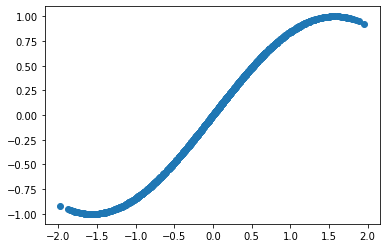

In [195]:
plt.scatter(X, Y)

In [188]:
import matplotlib.pyplot as plt


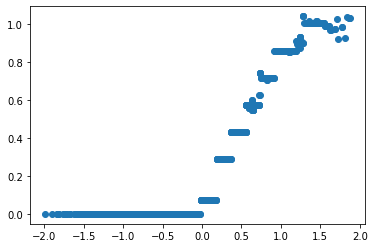

In [198]:
plt.scatter(X, N.Predict(X))

In [ ]:
def testS(x):
    print(np.matmul(np.ones((10,3)), x[0]))

In [ ]:
C = np.random.rand(6,3)

In [ ]:
def temp(x):
    print(x.size)

In [ ]:
X = np.random.randrange((3,8))
Y = np.asarray([2,3,4])

Y.dot(X)

AttributeError: ignored

temp(C)